# Eulerian Path

From: https://en.wikipedia.org/wiki/Eulerian_path

## Definitions

### Eulerian trail (or Eulerian path)
It is a path in a finite graph that visits every edge exactly once, nodes can be revisited. It exists only if:
  - The graph has 0 or 2 nodes with odd degree.  
      In that case these odd degree nodes will be the starting and ending vertices of the Eulerian trail.
  - The graph is connected

### Eulerian circuit (or Eulerian cycle)
It is an Eulerian path with same node as starting and ending vertex.
It exists only if:
  - The graph has all nodes with even degree

### Eulerian graph
It is a graph having a Eulerian circuit or having all even degree vertices. Those meanings are coincident in case of connected graphs.

### Semi-Eulerian graph
It is a graph having at least one Eulerian path but no Eulerian circuits, i.e. a connected graph with exactly two nodes of odd degree.

A classical example of the problem of Eulerian path finding is the puzzle of drawing a home with a single stroke without passing two times on same line. Here we have 2 nodes with odd degree.

In [1]:
import networkx as nx

Example = nx.Graph()
Example.add_nodes_from(range(1, 6))
Example.add_edges_from([(1, 2), (1, 3), (2, 3), (2, 5), (3, 4), (2, 4), (3, 5), (4, 5)])
fixed_layout = {1: [0, 0],
                2: [-1, -1],
                3: [1, -1],
                4: [-1, -3],
                5: [1, -3]}

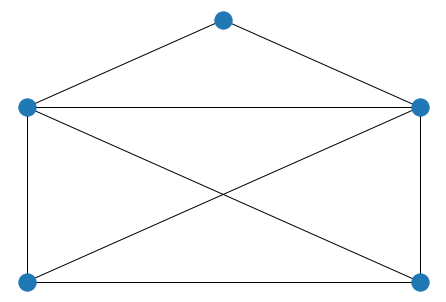

In [2]:
nx.draw(Example, pos = fixed_layout)

## Fleury's Algorithm

It is an elegant but inefficient algorithm based on bridge finding:  
  1. Choose a vertex of odd degree, if the graph has none choose an arbitrary vertex.
  2. If current vertex has just one edge, choose it.  
      Otherwise choose an edge whose deletion will keep the graph connected.
  3. Use this edge to reach the next node and delete the edge.
  4. If current vertex has no more edges it means that the Graph has no more edges.  
      Otherwise return to step 2
    
We will use every edge just once ($\mathcal{O}\ (\ |E|\ )$), but finding the right edge in step 2 involves a bridge-finding algorithm.
  - Tarjan's bridge-finding algorithm is $\mathcal{O}\ (\ |E|\ )$ as well $\Rightarrow$ the whole algorithm will be $\mathcal{O}\ (\ |E|^2\ )$
  - Thorup dynamic bridge-finding algorithm is $\mathcal{O}\ ((\ log\ ⁡|E|\ )^3\ log\ log\ |E|\ ) \Rightarrow$ the whole algorithm will be $\mathcal{O}\ (\ |E|\ \cdot\ (\ log\ ⁡|E|\ )^3\ log\ log\ |E|\ )$
  

### Example

In [3]:
import matplotlib.pyplot as plt
from random import choice

order = 0

def draw_graph(graph, attribute = None, figsize = None):
    plt.figure(figsize = figsize)
    cmap = plt.cm.Blues
    font_size = 25
    node_color = '#A0CBE2'    
    node_size = 1500
    
    if attribute != None:
        # Retrieving labels to be put on edges
        edge_labels = dict([((start, end, ), attr[attribute]) \
                            for start, end, attr in graph.edges(data = True)])
        # Setting different colors on edges basing on attribute value
        colors = [attr[attribute] for start, end, attr in graph.edges(data = True)]
        
        nx.draw_networkx_edge_labels(graph, pos = fixed_layout, edge_labels = edge_labels, font_size = font_size)
        
        sm = plt.cm.ScalarMappable(cmap = cmap, norm = plt.Normalize(vmin = min(colors), vmax=max(colors)))
        plt.colorbar(sm, ticks = colors)
        
    else:
        edge_labels = None
        colors = node_color
    
    nx.draw(graph, with_labels = True, pos = fixed_layout, \
            node_color = node_color, font_size = font_size, node_size = node_size, font_color = 'w', \
            edge_color = colors, width = 4, edge_cmap = cmap)
    plt.show()
    #plt.savefig(order)
    #order += 1
    
class NotConnectedGraph(Exception):
    def __init__(self, message):
        self.message = message
        
class TooManyOddNodes(Exception):
    def __init__(self, message):
        self.message = message   
        
def fleury(graph):
    # graph that will represent with direct edges
    # the eulerian trail
    trail = nx.DiGraph()    
    
    # Check if graph is connected
    if not nx.is_connected(graph):
        raise NotConnectedGraph("Graph is not connected")

    # Use of tmpGraph to leave graph as received
    tmpGraph = graph.copy()
    
    # Check which nodes have odd degree and raise exception if more than 2 have been found
    odd_degree_nodes = []
    for node in tmpGraph.nodes:
        if tmpGraph.degree(node) % 2 != 0:
            odd_degree_nodes.append(node)
            if len(odd_degree_nodes) > 2:
                raise TooManyOddNodes("Graph has at least 3 nodes with odd degree: " + str(odd_degree_nodes))            
    
    if len(odd_degree_nodes) == 1:
        raise TooManyOddNodes("Graph has 1 node with odd degree, it should have 0 or 2")
    
    order = 0
    print("Original graph")
    draw_graph(graph, figsize = (6, 6))
        
    # Start with a node with odd degree (if any)
    if len(odd_degree_nodes) > 0:
        node = odd_degree_nodes[0]
    else:
        node = choice(list(tmpGraph.nodes))
    
    end = False
    trail.add_node(node)
    order = 1
    while not end:
        # Search non-bridge edges
        not_bridge_edges = {*tmpGraph.edges(node)} - {*nx.bridges(tmpGraph, node)}
        if len(not_bridge_edges) > 0:
            next_node = not_bridge_edges.pop()[1]
                
        # If node has at least 1 neighbour
        elif len(tmpGraph[node]) > 0:
            next_node = [*tmpGraph[node]][0]
            
        else:
            end = True                
        
        if not end:
            trail.add_edge(node, next_node, order = order)
            tmpGraph.remove_edge(node, next_node)
            node = next_node
            print("Step #" + str(order))            
            draw_graph(trail, "order")
            order = order + 1

Original graph


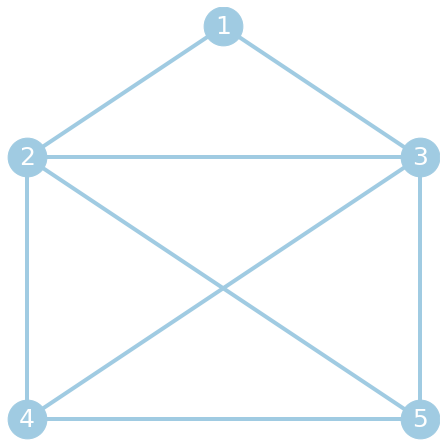

Step #1


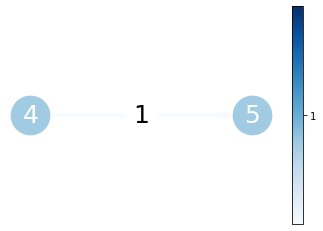

Step #2


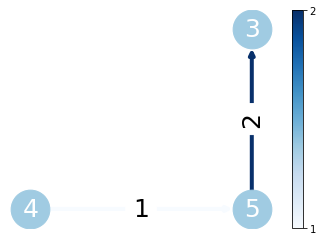

Step #3


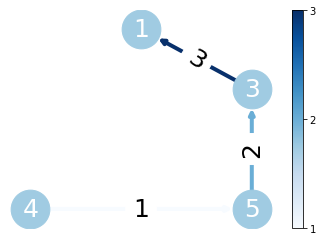

Step #4


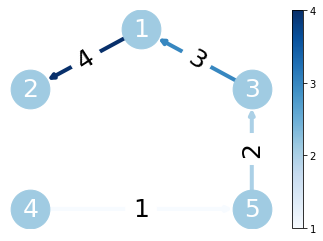

Step #5


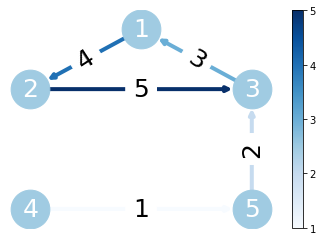

Step #6


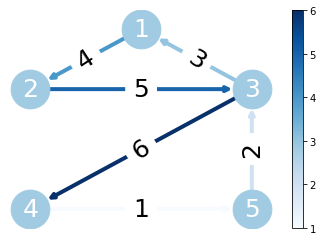

Step #7


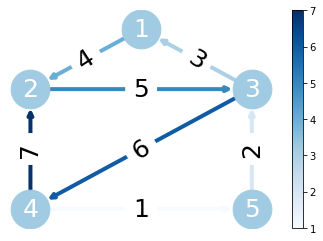

Step #8


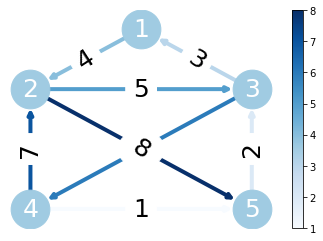

In [4]:
fleury(Example);

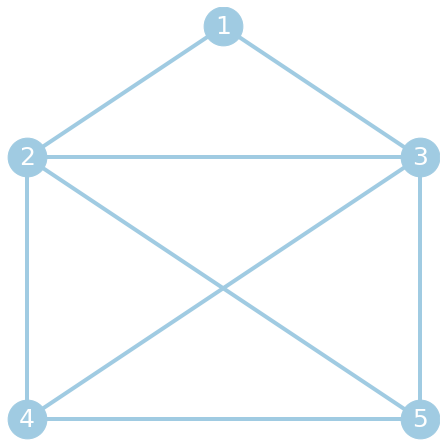

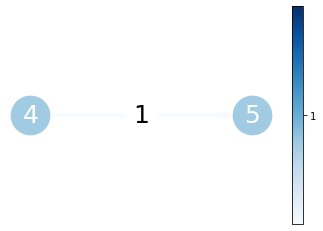

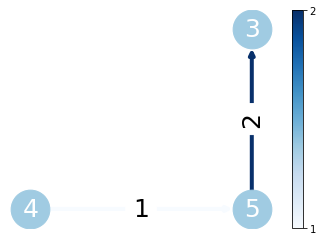

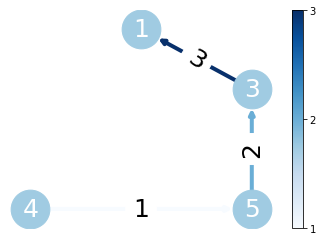

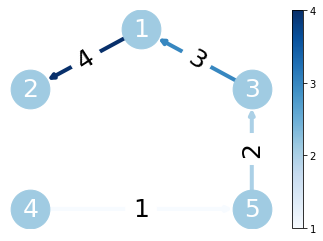

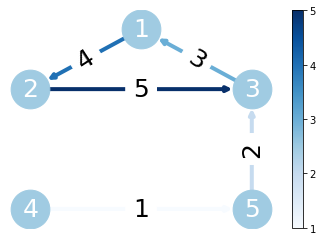

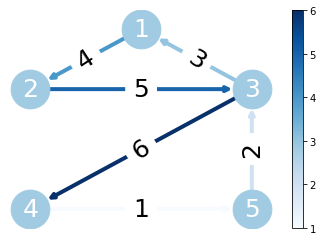

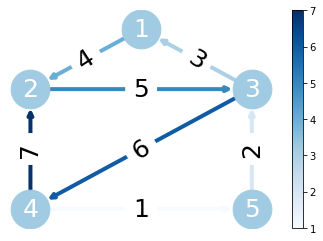

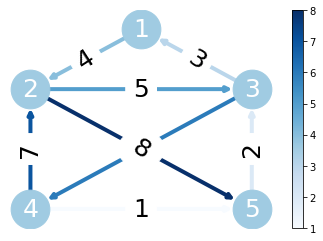

## Hierholzer's algorithm
Hierholzer's is more efficient than Fleury's algorithm:
  1. Choose any starting vertex v
  2. Follow a trail of edges from that vertex until returning to v.  
      It is not possible to get stuck at any vertex other than v, because the even degree of all vertices ensures that, when the trail enters another vertex w there must be an unused edge leaving w. The tour formed in this way is a closed tour, but may not cover all the vertices and edges of the initial graph.
  3. As long as there exists a vertex u that belongs to the current tour but that has adjacent edges not part of the tour, start another trail from u, following unused edges until returning to u, and join the tour formed in this way to the previous tour.

Since we assume the original graph is connected, repeating the previous step will exhaust all edges of the graph.

In [5]:
class Node:
    def __init__(self, initdata):
        self.data = initdata
        self.next = None
        self.prev = None

    def getData(self):
        return self.data

    def getNext(self):
        return self.next
    
    def getPrev(self):
        return self.prev

    def setData(self,newdata):
        self.data = newdata

    def setNext(self, next):
        self.next = next
        
    def setPrev(self, prev):
        self.prev = prev
        
    def __str__(self):
        return str(self.data)
        
class DoubleLinkedList:
    def __init__(self):
        self.head = None
        self.tail = None
        
    def __iter__(self):
        return DoubleLinkedListIterator(self)

    def isEmpty(self):
        return self.head == None
    
    def add_begin(self, item):
        temp = Node(item)
        if self.isEmpty():
            self.tail = temp
        else:
            self.head.setPrev(temp)
            temp.setNext(self.head)            
        self.head = temp
        
    def add_end(self, item):
        temp = Node(item)
        if self.isEmpty():
            self.head = temp
        else:
            self.tail.setNext(temp)
            temp.setPrev(self.tail)
        self.tail = temp
        
    def pop_begin(self):
        temp = self.head
        self.head = temp.next
        # If list is empty after pop
        if self.head == None:
            self.tail = None
        else:
            self.head.setPrev(None)
        return temp.getData()
        
    def pop_end(self):
        temp = self.tail
        self.tail = temp.prev
        # If list is empty after pop
        if self.tail == None:
            self.head = None
        else:
            self.tail.setNext(None)
        return temp.getData()
        
    def __str__(self):
        ret_str = "head --> "
        for node in self:
            if ret_str != "head --> ":
                ret_str += " <--> "
            ret_str += str(node)
        ret_str += " <-- tail"
        return ret_str
            
class DoubleLinkedListIterator:
    def __init__(self, doubleLinkedList):
        self.doubleLinkedList = doubleLinkedList
        self.pointer = doubleLinkedList.head
        
    def __next__(self):
        if self.pointer == None:
            raise StopIteration
        else:
            node = self.pointer
            self.pointer = self.pointer.next
            return node
        
def hierholzer(p_graph, p_viz=True):
    # Directed Graph that will contain Eulerian path
    trail = nx.DiGraph()

    # Double Linked List that will contain current path
    curr_path = DoubleLinkedList()

    # Check if p_graph is connected
    if not nx.is_connected(p_graph):
        raise NotConnectedGraph("Graph is not connected")

    # Use of tmp_graph to leave p_graph as received
    tmp_graph = p_graph.copy()

    # Check which nodes have odd degree and raise exception if more than 2 have been found
    odd_degree_nodes = []
    for node in tmp_graph.nodes:
        if tmp_graph.degree(node) % 2 != 0:
            odd_degree_nodes.append(node)
            if len(odd_degree_nodes) > 2:
                raise TooManyOddNodes("Graph has at least 3 nodes with odd degree: " + str(odd_degree_nodes))

    if len(odd_degree_nodes) == 1:
        raise TooManyOddNodes("Graph has 1 node with odd degree, it should have 0 or 2")

    draw_graph(p_graph, figsize=(6, 6))

    # Start with an odd node (if any)
    if len(odd_degree_nodes) > 0:
        node = odd_degree_nodes[0]
    else:
        node = choice(list(tmp_graph.nodes))

    end = False
    order = 1
    curr_path.add_end(node)
    prev_node = None
    while not end:
        # If node has at least 1 neighbour
        if len(tmp_graph[node]) > 0:
            next_node = [*tmp_graph[node]][0]

        else:
            # If we visited all edges we just need to add to DiGraph
            # all edges from curr_path
            if len(tmp_graph.edges()) == 0:
                end = True
                while not curr_path.isEmpty():
                    node = curr_path.pop_end()
                    trail.add_node(node)
                    if prev_node is not None:
                        trail.add_edge(prev_node, node, order=len(trail.edges()) + 1)
                        draw_graph(trail, "order")
                    prev_node = node
            # If there are still some edges in the Graph
            else:
                found = False
                end = True
                # We search within all already visited nodes in curr_path
                while not curr_path.isEmpty() and not found:
                    node = curr_path.pop_end()
                    # If extracted node from curr_path has at least a non-visited edge
                    # we set that node as next_node
                    if len(tmp_graph[node]) > 0:
                        next_node = [*tmp_graph[node]][0]
                        curr_path.add_end(node)
                        found = True
                        end = False
                    # Otherwise we add that node to trail
                    else:
                        if prev_node is None:
                            prev_node = node
                            trail.add_node(prev_node)
                        else:
                            trail.add_edge(prev_node, node, order=len(trail.edges()) + 1)
                            draw_graph(trail, "order")
                            prev_node = node

        if not end:
            tmp_graph.remove_edge(node, next_node)
            curr_path.add_end(next_node)
            node = next_node

        order = order + 1        

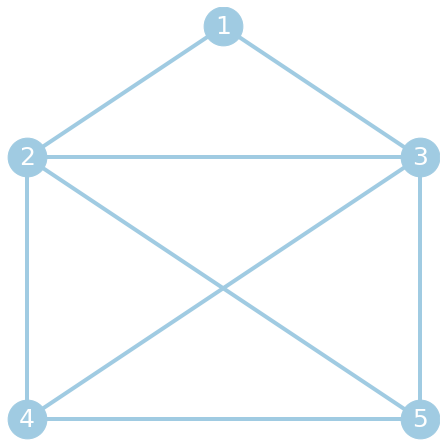

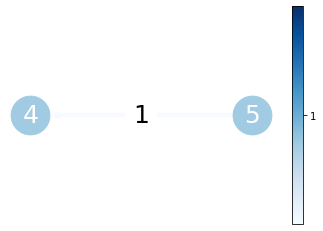

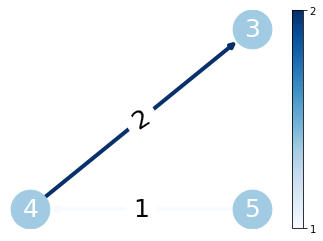

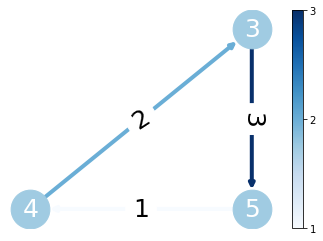

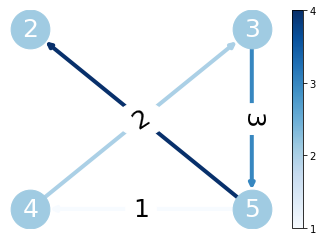

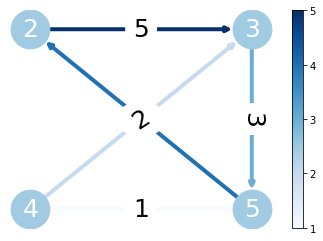

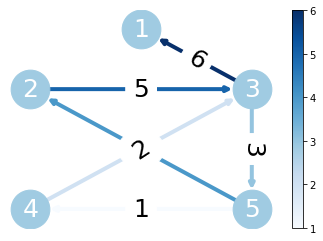

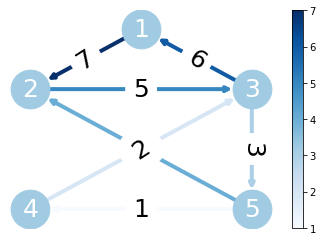

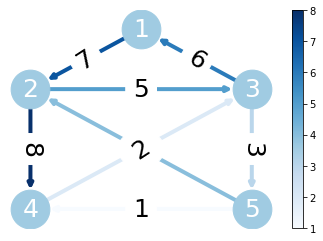

In [6]:
hierholzer(Example)

### Example

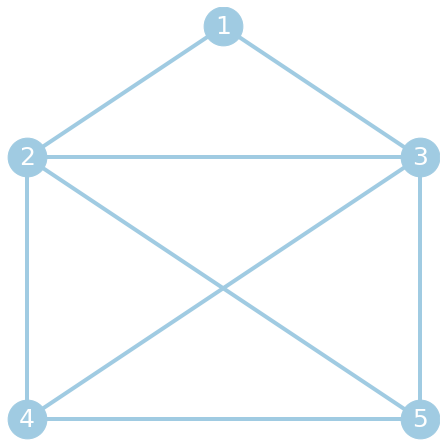

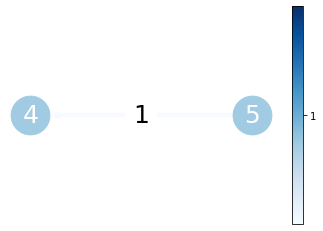

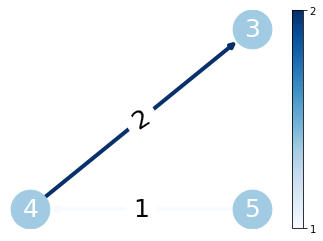

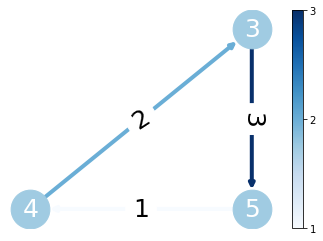

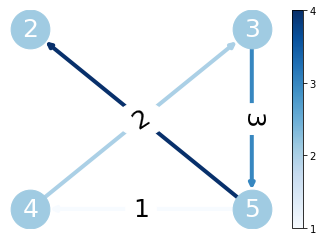

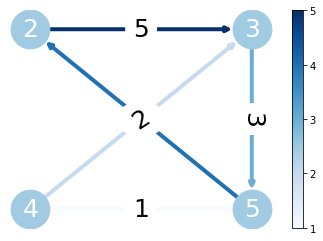

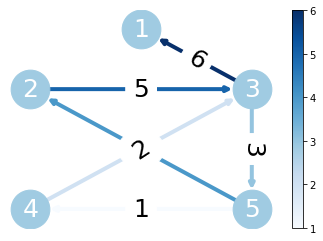

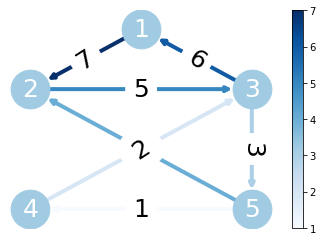

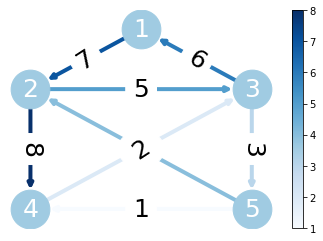

# Pseudo-peripheral vertices

From: https://en.wikipedia.org/wiki/Distance_(graph_theory)

## Definitions

### Central Vertex
In a graph of radius *r*, it is a node *v* having $\epsilon\ (\ v\ ) = r$

### Peripheral Vertex
In a graph of diameter *d* it is a node that is distant *d* from some other vertices.  
Formallly: $v$ is peripheral $\Leftrightarrow\ \epsilon\ (\ v\ )\ =\ d$.

### Pseudo-peripheral Vertex
It is a node with following property: for any vertex $u$, if $v$ is as far away from $u$ as possible, then $u$ is as far away from $v$ as possible.  
Formally: $u$ is pseudo-peripheral $\Leftrightarrow \forall\ v\ .\ d\ (\ u\ ,\  v\ )\ =\ \epsilon\ (\ u\ )$ holds $\epsilon\ (\ u\ ) = \epsilon\ (\ v\ )$.

Basing on that definition we can notice that any peripheral vertex is also a pseudo-peripheral node.

## Algorithm
In many algorithms starting with a peripheral vertex would reduce a lot the cost, but is often hard to find those nodes. In most circumstances a pseudo-peripheral vertex can be used to reduce calculation time. 
A pseudo-peripheral node can be found with the following algorithm:
 1. Choose a vertex u.
 2. Among all the vertices that are as far from u as possible, let v be one with minimal degree.  
   2.1. If $\epsilon\ (\ v\ )\ >\ \epsilon\ (\ u\ )\ \rightarrow$ set $u = v$ and return to step 2  
    2.2. Else $u$ is a pseudo-peripheral vertex.
    
Obviously:
  - The node identified by the algorithm depends on the starting node
  - If the algorithm finds a peripheral vertex it is returned

### Example
In our example we will use following graph. We can notice that:
  - *d* = 4
  - Nodes 6 and 7 are peripheral
  - Node 8 is pseudo-peripheral but not peripheral since it's eccentricity is 3
  
In some cases the algorithm returns node 8 because it is near enough to real peripheral nodes and its farest node (1) is such that d(1, 6) = d(1, 8) but 

In [7]:
import queue as qu

# Returns eccentricity of p_start_node and node at maximum distance having minimal degree
def bfs_peripheral(p_graph, p_start_node):
    bfs_que = qu.SimpleQueue()
    bfs_que.put((p_start_node, 0))
    max_dist_node = None
    eccentricity = -1
    queued = {p_start_node : None}
    while not bfs_que.empty():
        (act_node, dist) = bfs_que.get()        
        leaf = True
        for node in p_graph[act_node]:
            if node not in queued:
                if leaf:
                    leaf = False
                queued[node] = None
                bfs_que.put((node, dist + 1))
            
        if leaf and \
        (dist > eccentricity or \
         (dist == eccentricity and \
          p_graph.degree[max_dist_node] > p_graph.degree[act_node])):
            max_dist_node = act_node
            eccentricity = dist
            
    return (eccentricity, max_dist_node)

# The function has a p_start_node param to force the algorithm starting point
def pseudo_peripheral(p_graph, p_start_node = None):
    if p_start_node == None:
        p_start_node = choice(list(p_graph.nodes))
    
    u = p_start_node
    eccentricity_u, v = bfs_peripheral(p_graph, u)
    print("Starting from node: " + str(u) + ", ecc(" + str(u) + ") = " + str(eccentricity_u) + ", farest node from " + str(u) + " with minimal degree is " + str(v))
    while True:
        eccentricity_v, z = bfs_peripheral(p_graph, v)        
        print("ecc(" + str(v) + ") = " + str(eccentricity_v) + ", farest node from  " + str(v) + " with minimal degree is " + str(z))
        if eccentricity_v == eccentricity_u:
            print("Pseudo-peripheral node found: " + str(u))
            break
        
        eccentricity_u = eccentricity_v
        u = v
        v = z    
        
Example = nx.Graph()
Example.add_nodes_from(range(1,9))
Example.add_edges_from([(6, 4), (4, 2), (4, 8), (2, 1), (1, 3), (3, 5), (5, 7), (5, 8)])
fixed_layout = {1: [0, 0],
                2: [-1, -1],
                3: [1, -1],
                4: [-1, -2],
                5: [1, -2],
                6: [-2, -3],
                7: [2, -3],
                8: [0, -3]}        

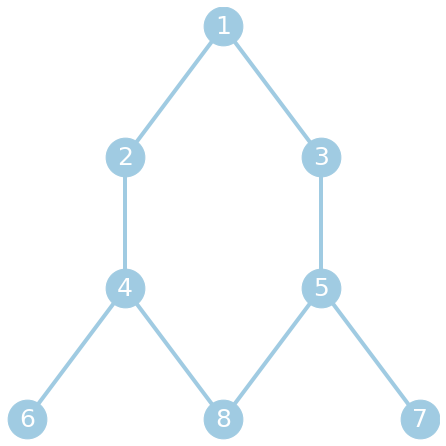

In [12]:
draw_graph(Example, figsize=(6, 6))

In [9]:
pseudo_peripheral(Example)

Starting from node: 4, ecc(4) = 3, farest node from 4 with minimal degree is 7
ecc(7) = 4, farest node from  7 with minimal degree is 6
ecc(6) = 4, farest node from  6 with minimal degree is 7
Pseudo-peripheral node found: 7


If previous execution returned a peripheral node (6 or 7) we can "force" the starting node of the function, in this way we can see that node 8 will be returned.

In [10]:
pseudo_peripheral(Example, 8)

Starting from node: 8, ecc(8) = 3, farest node from 8 with minimal degree is 1
ecc(1) = 3, farest node from  1 with minimal degree is 6
Pseudo-peripheral node found: 8
